In [1]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/Othercomputers/My MacBook Air/thesis/model'

Mounted at /content/drive


In [2]:
import gdown

url = 'https://drive.google.com/file/d/14kTCUVe3OUjcsYYVh0f_8lrhn8csrh9M/view?usp=share_link'
output = '2021.nc'
gdown.download(url=url, output=output, quiet=False, fuzzy=True)

url = 'https://drive.google.com/file/d/1eH6ouJvO5lNF7ueGReaWRmbG_NFUj9ox/view?usp=share_link'
output = '2021_idata.nc'
gdown.download(url=url, output=output, quiet=False, fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=14kTCUVe3OUjcsYYVh0f_8lrhn8csrh9M
To: /content/2021.nc
100%|██████████| 2.09G/2.09G [00:20<00:00, 101MB/s]
Downloading...
From: https://drive.google.com/uc?id=1eH6ouJvO5lNF7ueGReaWRmbG_NFUj9ox
To: /content/2021_idata.nc
100%|██████████| 12.9M/12.9M [00:00<00:00, 17.7MB/s]


'2021_idata.nc'

# imports

In [3]:
import numpy as np
import pandas as pd
import xarray as xr

import pymc as pm
import arviz as az

import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
pm.__version__

'5.1.2'

In [5]:
RANDOM_SEED = 5434
rng = np.random.default_rng(RANDOM_SEED)

az.style.use('arviz-darkgrid')

# data

In [6]:
ds = xr.load_dataset('2021.nc').sel(
    x=slice(95, 100), 
    y=slice(55, 60), 
    time=slice('2021-08-01', '2021-08-31'))

idata = az.from_netcdf('2021_idata.nc')

In [7]:
shape = ds.counts.shape

In [11]:
prediction = xr.DataArray(
    data=np.reshape(
      idata.posterior_predictive.pred_zero.to_numpy(), 
      (1, -1, *shape)), 
    coords={'chain': (['chain'], idata.posterior_predictive.chain.values),
            'draw': (['draw'], idata.posterior_predictive.draw.values),
            'time': (['time'], ds.time.values),
            'x': (['x'], ds.x.values),
            'y': (['y'], ds.y.values)})


In [12]:
prediction_sum = prediction.sum(['x', 'y']).isel(chain=0)
hdi_sum = az.hdi(prediction.sum(['x', 'y']))
mean_sum = prediction_sum.mean('draw')
obs_sum = ds.counts.sum(['x', 'y'])

# example

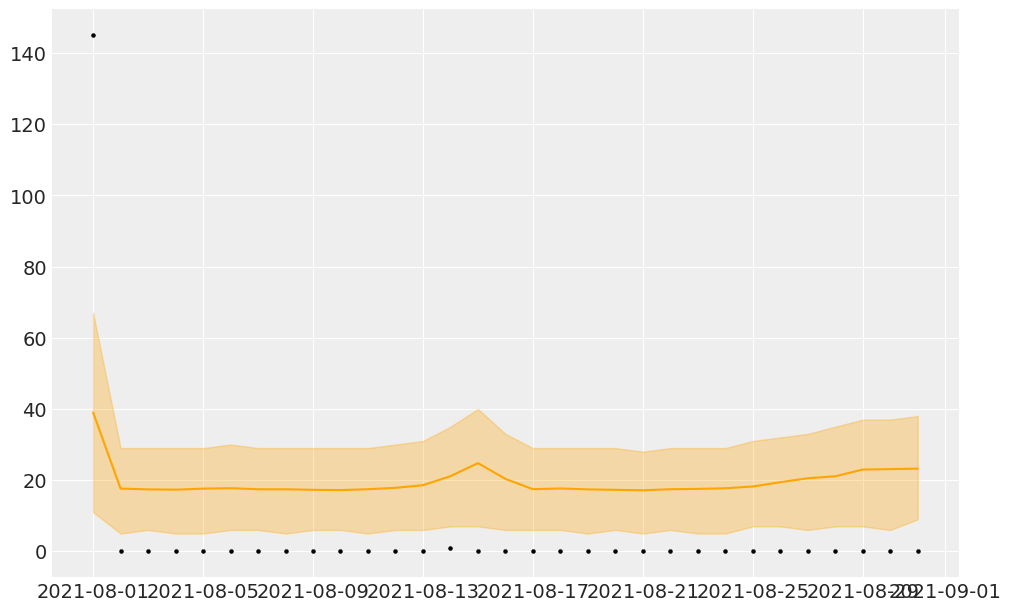

In [13]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(prediction.time, mean_sum, color='orange')
ax.fill_between(prediction.time,
                hdi_sum.x.sel(hdi='lower'), 
                hdi_sum.x.sel(hdi='higher'),
                alpha=.3, color='orange')
ax.scatter(prediction.time, obs_sum, color='black', s=5)

# old

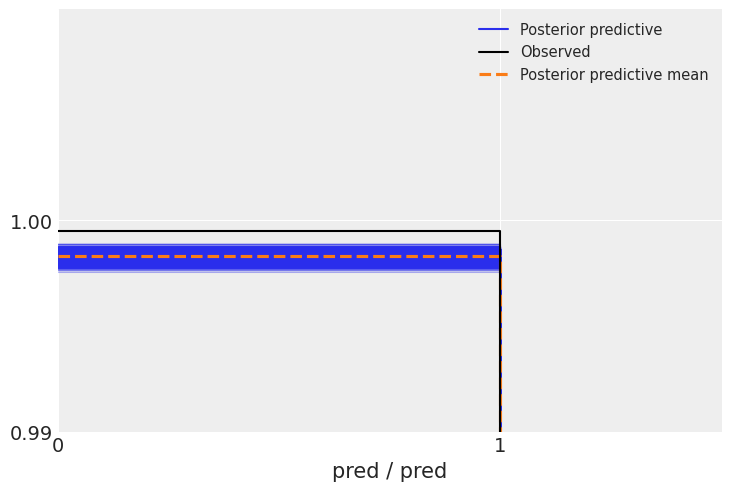

In [ ]:
fig, ax = plt.subplots()
ax.set_ylim(bottom=.99, top=1.01)
ax.set_xlim(right=1.5)
az.plot_ppc(posterior, ax=ax)
ax.set_yticks(np.linspace(.99, 1, 2))
ax.set_xticks(np.linspace(0, 1, 2))

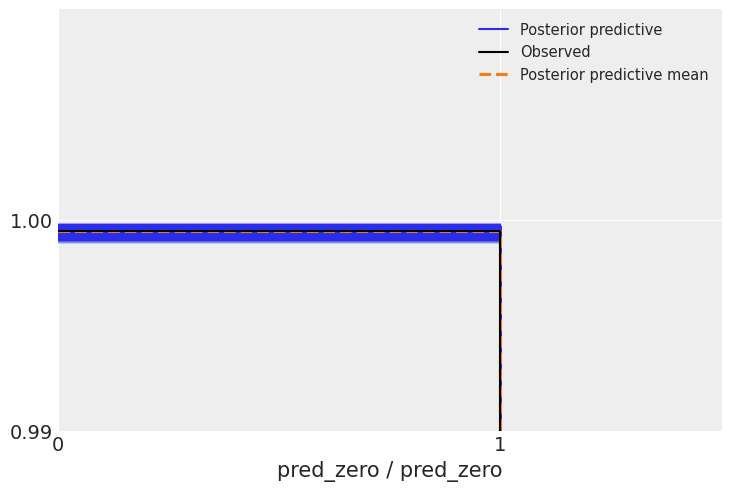

In [ ]:
fig, ax = plt.subplots()
ax.set_ylim(bottom=.99, top=1.01)
ax.set_xlim(right=1.5)
az.plot_ppc(posterior_zero, ax=ax)
ax.set_yticks(np.linspace(.99, 1, 2))
ax.set_xticks(np.linspace(0, 1, 2))

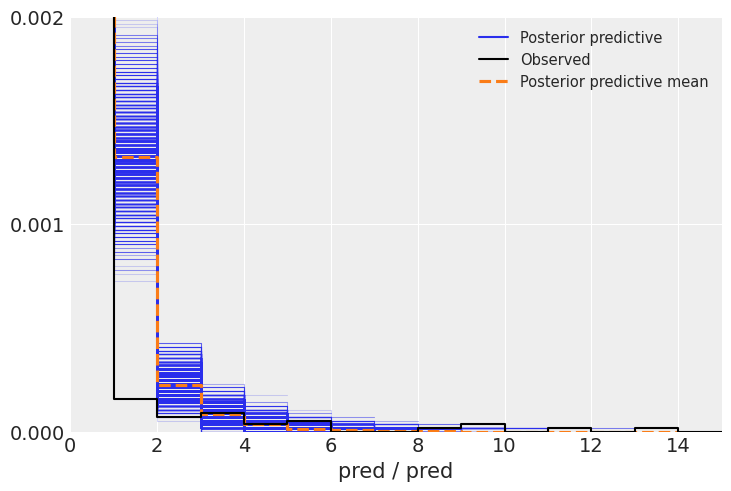

In [ ]:
fig, ax = plt.subplots()
ax.set_ylim(top=.002)
ax.set_xlim(right=15)
az.plot_ppc(posterior, ax=ax)
ax.set_yticks(np.linspace(0, .002, 3))

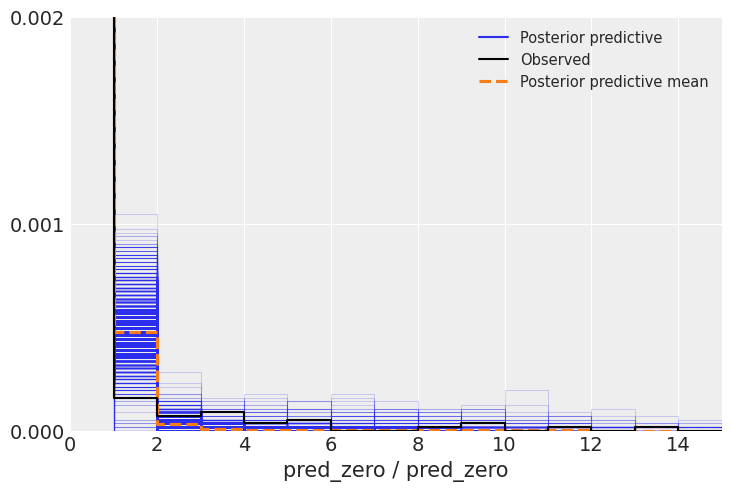

In [ ]:
fig, ax = plt.subplots()
ax.set_ylim(top=.002)
ax.set_xlim(right=15)
az.plot_ppc(posterior_zero, ax=ax)
ax.set_yticks(np.linspace(0, .002, 3))

## score

In [ ]:
pm.summary(idata)['mean']

Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)


[-8.386, 0.407]

In [ ]:
beta0, beta1 = pm.summary(idata)['mean']
beta0_hdi3, beta1_hdi3 = pm.summary(idata)['hdi_3%']
beta0_hdi97, beta1_hdi97 = pm.summary(idata)['hdi_97%']

Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)


In [ ]:
pred = np.exp(beta0 + beta1 * X_test)
pred_hdi3 = np.exp(beta0_hdi3 + beta1_hdi3 * X_test)
pred_hdi97 = np.exp(beta0_hdi97 + beta1_hdi97 * X_test)

In [ ]:
pred

14621    0.000230
49113    0.000395
68114    0.000890
12675    0.000231
76668    0.000473
           ...   
64333    0.000270
24959    0.000234
37544    0.001792
77907    0.000289
6641     0.000269
Name: X, Length: 24190, dtype: float64

In [ ]:
df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)

In [ ]:
ds

<xarray.Dataset>
Dimensions:      (x: 51, y: 51, time: 31)
Coordinates:
  * x            (x) float64 95.0 95.1 95.2 95.3 95.4 ... 99.7 99.8 99.9 100.0
  * y            (y) float64 55.0 55.1 55.2 55.3 55.4 ... 59.7 59.8 59.9 60.0
  * time         (time) datetime64[ns] 2021-08-01 2021-08-02 ... 2021-08-31
    spatial_ref  int32 0
Data variables:
    FWI          (time, y, x) float64 0.4043 0.4149 0.4229 ... 3.922 3.737 3.707
    counts       (time, y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    Conventions:  CF-1.7

In [ ]:
df_test

,X,y
14621,2.772019e-07,0
49113,1.326682e+00,0
68114,3.328950e+00,0
12675,6.804498e-03,0
76668,1.771161e+00,0
...,...,...
64333,3.957777e-01,0
24959,4.026982e-02,0
37544,5.052926e+00,0
77907,5.582843e-01,0


<Axes: xlabel='X', ylabel='y'>

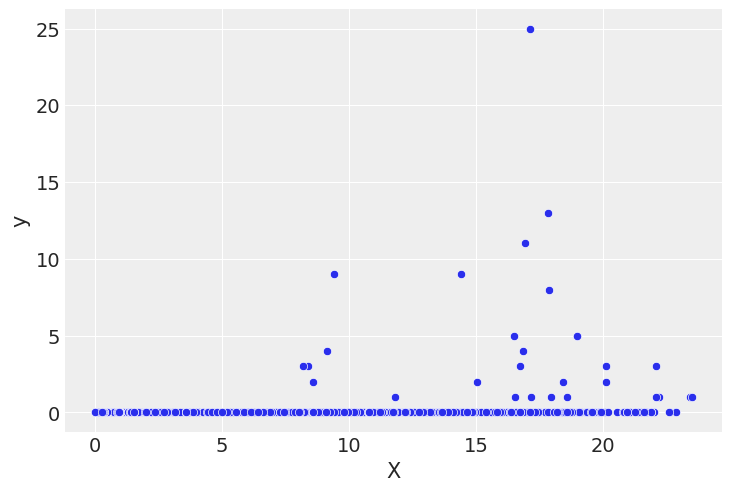

In [ ]:
sns.scatterplot(data=df_train, x='X', y='y')

KeyboardInterrupt: ignored

Error in callback <function _draw_all_if_interactive at 0x7f3822e4f700> (for post_execute):


KeyboardInterrupt: ignored

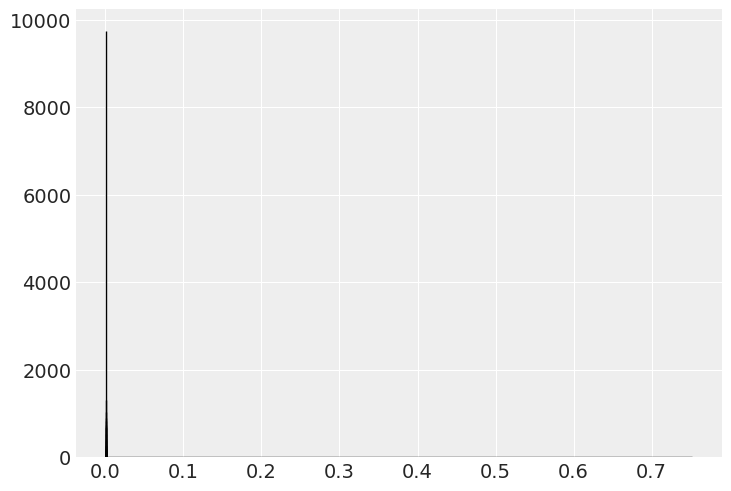

In [ ]:
sns.histplot(pred)